# Algoritmo evolutivo para optimización con restricciones – Internal feasibility first – max version

### Descripción

<font size="4"> Algoritmo evolutivo para optimización continua con restricciones (minimización), enfoque "primero factibilidad", interno, versión max.

### Componentes

- <font size="3"> Representación real
    
- <font size="3"> Manejo de restricciones con enfoque "primero factibilidad", interno, versión max
    
- <font size="3"> Selección por torneo binario
    
- <font size="3"> Muestreo estocástico con reemplazamiento
    
- <font size="3"> Sustitución $(\mu+\lambda)$
    
- <font size="3"> Elitista

- <font size="3"> Cruce uniforme, aritmético y SBX

- <font size="3"> Mutación uniforme, 'small' y polinomial
   
### Comentarios
    
- <font size="3"> Se requiere ordenar una población de $2 \cdot N$ individuos con los $\mu$ padres más los $\lambda$ hijos, $\mu=\lambda=N$.   
    
- <font size="3"> Problemas de test obtenidos de:

    <font size="3"> https://en.wikipedia.org/wiki/Test_functions_for_optimization#Test_functions_for_constrained_optimization
    
    <font size="3"> http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO.htm
    
---

### Requerimientos

In [1]:
import numpy as np
import math
from tqdm import tqdm
import landscapes.single_objective as lso
import matplotlib.pyplot as plt
import heapq 

### Parámetros del algoritmo evolutivo
- $G$: Número de generaciones
- $N$: Tamaño de la población
- $random\_state$: Semilla para reproducibilidad
- $prob$: Probabilidades
  - $prob\_cross$: Probabilidades de cruce
    - $p\_c$: Probabilidad de cruce
    - $uniform\_crossover\_probability$: Probabilidad de cruce uniforme
    - $arithmetic\_crossover\_probability$: Probabilidad de cruce aritmético
    - $SBX\_crossover\_probability$: Probabilidad de cruce SBX
  - $prob\_mutation$: Probabilidades de mutación
    - $p\_m$: Probabilidad de mutación
    - $uniform\_mutation\_probability$: Probabilidad de mutación uniforme 
    - $small\_mutation\_probability$: Probabilidad de mutación small 
    - $polynomial\_mutation\_probability$: Probabilidad de mutación small 
    - $epsilon$: Máximo cambio en mutación small

In [2]:
G = 10000
N = 100
random_state = 1

p_c = 0.7
uniform_crossover_probability = 0.4 
arithmetic_crossover_probability = 0.2
SBX_crossover_probability = 0.4

p_m = 0.1
uniform_mutation_probability = 0.4
small_mutation_probability = 0.2
polynomial_mutation_probability = 0.4
epsilon = 1e-6

prob_cross = p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability
prob_mutation = p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon
prob = prob_cross,prob_mutation

### Definición del problema de optimización con restricciones
- $L$: Límite inferior de espacio de búsqueda
- $U$: Límite superior de espacio de búsqueda
- $f$: Función objetivo
- $g$: Restricciones (se cumplen las restricciones si son menor o igual que cero)

In [3]:
# Rosenbrock function constrained with a cubic and a line

def Rosenbrock_objective(x):
    f = (1-x[0])**2+100*(x[1]-x[0]**2)**2
    return f

def Rosenbrock_constraints(x):
    g = np.zeros(2)
    g[0] = (x[0]-1)**3-x[1]+1 # <=0
    g[1] = x[0]+x[1]-2 # <=0
    return g

def Rosenbrock():
    n = 2 # Número de variables de decisión    
    L = np.array([-1.5,-0.5])
    U = np.array([1.5,2.5])
    f = Rosenbrock_objective
    g = Rosenbrock_constraints
    return L,U,f,g

# G3 problem
  
def G3_objective(x):
    f = (np.sqrt(x.size)**x.size)*np.prod(x)
    return -f

def G3_constraints(x):
    g = np.zeros(1)
    g[0] = np.abs(sum([i*i for i in x])-1)-1e-4
    return g

def G3():
    n = 10 # Número de variables de decisión
    L = np.full(n, 0.0)
    U = np.full(n, 1.0)
    f = G3_objective
    g = G3_constraints
    return L,U,f,g

# G1 problem

def G1_objective(x):
    f = 5*sum(x[0:4])-5*sum([x[i]*x[i] for i in range(4)])-sum(x[4:])
    return f

def G1_constraints(x):
    g = np.zeros(9)
    g[0] = 2*x[0]+2*x[1]+x[9]+x[10]-10
    g[1] = 2*x[0]+2*x[2]+x[9]+x[11]-10
    g[2] = 2*x[1]+2*x[2]+x[10]+x[11]-10    
    g[3] = -8*x[0]+x[9]
    g[4] = -8*x[1]+x[10]    
    g[5] = -8*x[2]+x[11]
    g[6] = -2*x[3]-x[4]+x[9]
    g[7] = -2*x[5]-x[6]+x[10]    
    g[8] = -2*x[7]-x[8]+x[11]
    return g 

def G1():
    n = 13 # Número de variables de decisión
    L = np.full(n, 0.0)
    U = np.full(n, 1.0)
    U[9] = 100
    U[10] = 100
    U[11] = 100
    f = G1_objective
    g = G1_constraints
    return L,U,f,g

L,U,f,g = Rosenbrock()
#L,U,f,g = G3()
#L,U,f,g = G1()

### Definición de individuo

In [4]:
class Individuo:
    def __init__(self,n):
        self.x = np.zeros(n)
        self.f = 0.0
        self.g = 0.0
    def __lt__(self, ind):
        if self.g <= 0.0 and ind.g <= 0.0:
            return self.f < ind.f
        return self.g < ind.g

### Inicialización de la población

In [5]:
def InitializePopulation(P,L,U):
    for I in P:
        I.x[:] = np.random.uniform(L, U, I.x.size)

### Función de evaluación

In [6]:
def evaluate(I,f,g):           
    I.f = f(I.x)
    I.g = max(g(I.x))

### Copia de individuo

In [7]:
def copia(I1, I2):
    np.copyto(I1.x, I2.x)
    I1.f = I2.f   
    I1.g = I2.g

### Selección por torneo binario

In [8]:
def binary_tournament_selection(P):
    return min(np.random.choice(P,2,replace=False))

### Cruce
- Cruce con probabilidad $p\_c$ y:
    - cruce uniforme (con probabilidad $uniform\_crossover\_probability$)
    - cruce aritmético (con probabilidad $arithmetic\_crossover\_probability$)
    - cruce SBX en otro caso

In [9]:
def uniform_crossover(x1,x2):
    for l in range(x1.size):
        if np.random.random()<=0.5:
            x1[l], x2[l] = x2[l], x1[l] 
            
def arithmetic_crossover(x1,x2):
    alpha = np.random.random()
    x1[:], x2[:] = alpha*x1+(1-alpha)*x2, alpha*x2+(1-alpha)*x1
        
def SBX_crossover(x1,x2,L,U):
    eta = 10
    u = np.random.rand()
    if u <= 0.5:
        beta = (2 * u) ** (1 / (eta + 1))
    else:
        beta = (1 / (2 * (1 - u))) ** (1 / (eta + 1))    
    x1[:], x2[:] = 0.5*((1+beta)*x1+(1-beta)*x2), 0.5 *((1-beta)*x1+(1+beta)*x2)
    x1[:], x2[:] = np.clip(x1,L,U), np.clip(x2,L,U)
    
def crossover(x1,x2,prob_cross,L,U): 
    p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability = prob_cross
    if np.random.random()<=p_c:
        r = np.random.random()
        if r<=uniform_crossover_probability:
            uniform_crossover(x1,x2)
        elif r<=uniform_crossover_probability+arithmetic_crossover_probability:
            arithmetic_crossover(x1,x2)
        else:
            SBX_crossover(x1,x2,L,U)

### Mutación
- Mutación con probabilidad $p\_m$ y:
    - mutación uniforme numerica (con probabilidad $uniform\_mutation\_probability$)
    - mutación small (con probabilidad $small\_mutation\_probability$) 
    - mutación polinomial en otro caso

In [10]:
def uniform_mutation(x,p_m,L,U):
    for l in range(x.size):
        if np.random.random()<=p_m:
            x[l] = np.random.uniform(L[l],U[l])
    
def small_mutation(x,p_m,epsilon,L,U):
    for l in range(x.size):
        if np.random.random()<=p_m:
            if np.random.random()<=0.5:
                x[l] += np.random.uniform(0,epsilon)
            else:
                x[l] -= np.random.uniform(0,epsilon)
    x[:] = np.clip(x,L,U)
                
def polynomial_mutation(x,p_m,L,U):
    eta_m = 20
    for l in range(x.size):
        if np.random.random()<=p_m:
            u = np.random.random()
            if u<=0.5:
                 x[l] += ((2*u)**(1/(1+eta_m))-1)*(x[l]-L[l])
            else:
                 x[l] += (1-(2*(1-u))**(1/(1+eta_m)))*(U[l]-x[l])
    x[:] = np.clip(x,L,U)
                
def mutation(x,prob_mutation,L,U):
    p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon = prob_mutation
    r = np.random.random()
    if r<=uniform_mutation_probability:
        uniform_mutation(x,p_m,L,U)
    elif r<=uniform_mutation_probability+small_mutation_probability:
        small_mutation(x,p_m,epsilon,L,U)
    else:
        polynomial_mutation(x,p_m,L,U)

### Progreso del algoritmo

In [11]:
def IniciaProgreso(P,G):
    best_outputs_f = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    best_outputs_g = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    progression_bar = tqdm()
    ActualizaProgreso(P,0,best_outputs_f,best_outputs_g,progression_bar)    
    return best_outputs_f,best_outputs_g,progression_bar
    
def ActualizaProgreso(P,gen,best_outputs_f,best_outputs_g,progression_bar):
    best_individuo = min(P)
    progression_bar.set_description("Generation: %s Objective: %s Feasibility: %s " % (str(gen), str(best_individuo.f), str(best_individuo.g)))
    best_outputs_f[gen] = best_individuo.f # Añadir mejor fitness (para visualización)
    best_outputs_g[gen] = best_individuo.g
    progression_bar.update(1)

### Algoritmo evolutivo

In [12]:
def EA(G,N,prob,f,g,L,U,random_state):
    
    np.random.seed(random_state)
    
    prob_cross,prob_mutation = prob
    p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability = prob_cross
    p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon = prob_mutation
    
    # Aserciones
    
    assert G >= 1, "El número de generaciones debe ser mayor o igual que 1."  
    assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."  
    
    def AssertProbability(p):
        assert p>=0 and p<=1, "La probabilidad debe estar entre 0 y 1."

    AssertProbability(p_c)
    AssertProbability(uniform_crossover_probability)
    AssertProbability(arithmetic_crossover_probability)
    AssertProbability(SBX_crossover_probability)    
    assert uniform_crossover_probability + arithmetic_crossover_probability + SBX_crossover_probability == 1.0, "Error en suma de probabilidades de cruce."
    
    AssertProbability(p_m)
    AssertProbability(uniform_mutation_probability)
    AssertProbability(small_mutation_probability)
    AssertProbability(polynomial_mutation_probability)
    assert uniform_mutation_probability + small_mutation_probability + polynomial_mutation_probability == 1.0, "Error en suma de probabilidades de mutación."

    n = L.size # Número de variables de decisión  
    
    # Crear población inicial con N individuos
    P = [Individuo(n) for _ in range(N)]
    InitializePopulation(P,L,U)
    
    # Evaluar población inicial
    for I in P:
        evaluate(I,f,g)
    
    # Crear población auxilar 
    Q = [Individuo(n) for _ in range(2*N)]
    
    # Evoluciona durante G generaciones
    best_outputs_f,best_outputs_g,progression_bar = IniciaProgreso(P,G)    
    for gen in range(1,G+1):
        for i in range(N):
            copia(Q[i],P[i])
        i=N
        while i < 2*N:
            copia(Q[i],binary_tournament_selection(P))
            copia(Q[i+1],binary_tournament_selection(P))
            crossover(Q[i].x,Q[i+1].x,prob_cross,L,U)
            mutation(Q[i].x,prob_mutation,L,U)
            mutation(Q[i+1].x,prob_mutation,L,U)
            evaluate(Q[i],f,g)
            evaluate(Q[i+1],f,g)
            i += 2  
        R = heapq.nsmallest(N,Q)
        for i in range(N):
            copia(P[i],R[i])
        ActualizaProgreso(P,gen,best_outputs_f,best_outputs_g,progression_bar)
        # print([I.x for I in P])
    best_individuo = min(P)
    return best_outputs_f,best_outputs_g, best_individuo.f, best_individuo.g, best_individuo.x

### Ejecución del algoritmo evolutivo

In [13]:
%%time
best_outputs_f, best_outputs_g, best_f, best_g, best_solution = EA(G,N,prob,f,g,L,U,random_state)
print("x: ",best_solution)
print("f: ",best_f)
print("maxg: ",best_g)

Generation: 10000 Objective: 6.805058389399289e-19 Feasibility: -3.6415315207705135e-13 : : 10001it [03:06, 53.72it/s]

x:  [1. 1.]
f:  6.805058389399289e-19
maxg:  -3.6415315207705135e-13
CPU times: total: 2min 58s
Wall time: 3min 6s


### Visualización de la evolución del algoritmo

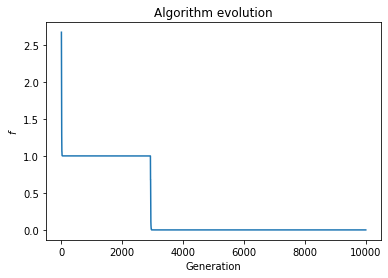

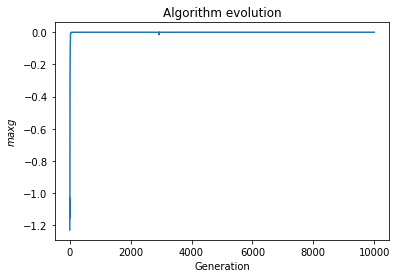

In [14]:
def VisualizaEvolucion(best_outputs,ylabel,file):
    fig, ax = plt.subplots()
    ax.set_title("Algorithm evolution")
    plt.plot(best_outputs)
    plt.xlabel("Generation")
    plt.ylabel(ylabel)
    #matplotlib.pyplot.savefig(file)    
    plt.show()

VisualizaEvolucion(best_outputs_f,"$f$","EvolutionMuLambdaObjective.png")
VisualizaEvolucion(best_outputs_g,"$maxg$","EvolutionMuLambdaMaxConstraint.png")